# Определение стоимости автомобилей

## Подготовка данных

In [1]:
!pip install pandas_profiling
import pandas as pd # библиотека Pandas
import pandas_profiling # профилирование данных
from sklearn.model_selection import train_test_split # разделение выборок
from sklearn.ensemble import RandomForestRegressor # модель случайный лес
from sklearn.model_selection import GridSearchCV # поиск по сетке
import time # подсчет времени
from lightgbm import LGBMRegressor # модель бустинга
from sklearn.metrics import mean_squared_error # среднеквадратичная ошибка
from sklearn.preprocessing import OneHotEncoder # OHE

/tmp/ipykernel_163/3682271836.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling # профилирование данных


In [2]:
data = pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Данные содержат 354 тысячи 369 строк и 16 столбцов со следующей информацией:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя;
- Price — цена автомобиля в евро.

Оценим данные при помощи `pandas_profiling`. Но сначала удалим столбцы, которые не понадобятся для обучения модели: дата скачивания анкеты, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца, дата последней активности пользователя.

In [3]:
data = data.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Датасет содержит 21543 явных дубликата их надо будет удалить. В категориальных признаках содержится много пропусков, а количественные содержат большое количество нулей, например в столбце `Power` 40 тысяч нулевых значений, что составляет 11.4% от всех данных. Также содержится высокое количество выбросов в столбцах: год регистрации автомобиля, мощность.

Сначала удалим дубликаты.

In [4]:
data = data.drop_duplicates()
data = data.reset_index()

Заполним заглушкой пропуски в категориальных столбцах.

In [5]:
nan_cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Repaired']
data[nan_cat] = data[nan_cat].fillna('unknown')

Оценим распределение мощности машин.

count    326826.000000
mean        110.244705
std         195.886373
min           0.000000
25%          69.000000
50%         105.000000
75%         141.000000
max       20000.000000
Name: Power, dtype: float64


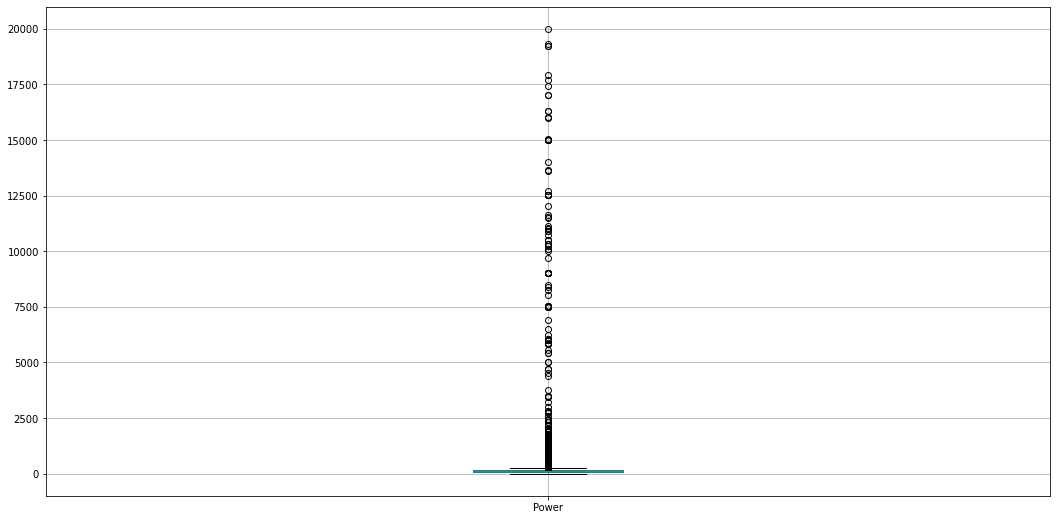

In [6]:
print(data['Power'].describe())
data.boxplot(column='Power', figsize=(18, 9));

Оставим те данные, где мощность больше 0 и меньше 2.5 тысяч л.с.

In [7]:
data = data.query('0 < Power < 2500')

Оценим распределение года регистрации автомобиля.

count    289690.000000
mean       2003.442218
std          35.298769
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


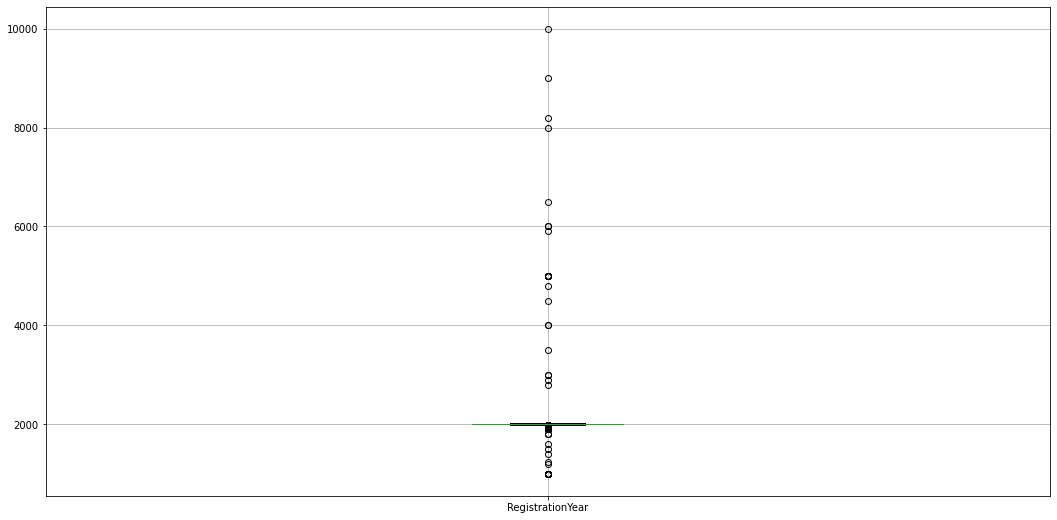

In [8]:
print(data['RegistrationYear'].describe())
data.boxplot(column='RegistrationYear', figsize=(18, 9));

Оставим данные, где год находится между 1970 и 2016.

In [9]:
data = data.query('1969 < RegistrationYear < 2017')

Оценим распределение цены.

count    278697.000000
mean       4722.411102
std        4610.954074
min           0.000000
25%        1211.000000
50%        2999.000000
75%        6900.000000
max       20000.000000
Name: Price, dtype: float64


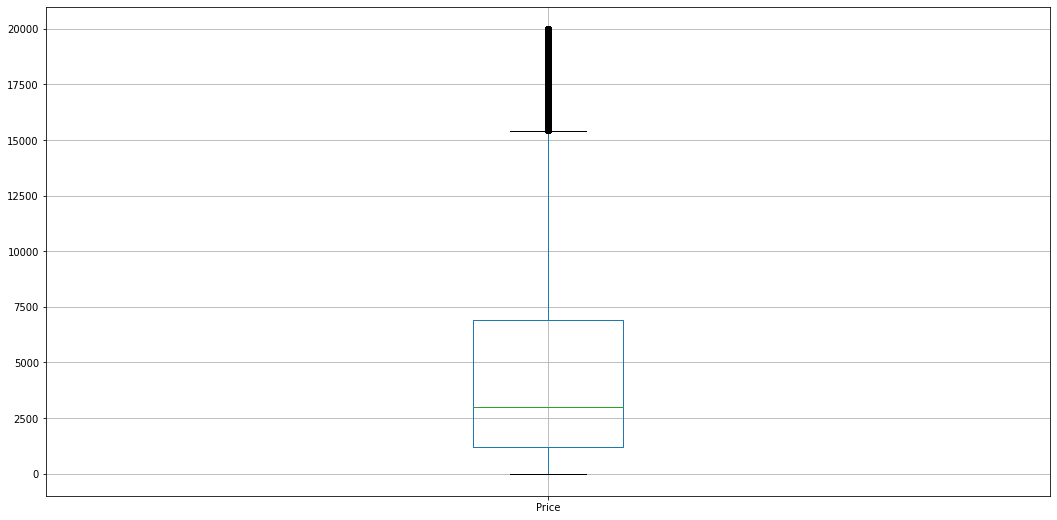

In [10]:
print(data['Price'].describe())
data.boxplot(column='Price', figsize=(18, 9));

Ограничим цену не меньше 100 евро.

In [11]:
data = data.query('99 < Price')

Данные готовы к обучению.

## Обучение моделей

Закодируем категориальные признаки.

In [12]:
ohe_cat = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']
data = pd.get_dummies(data, columns = ohe_cat, drop_first=True)
data['Brand_Model'] = data.groupby(['Brand', 'Model'])['Price'].transform('mean')
data = data.drop(columns=['Brand', 'Model'], axis=1)

Разделим выборку на обучающую и тестовую.

In [14]:
features = data.drop(columns='Price', axis=1)
target = data['Price']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=75)

### Случайный лес

Обучим модель случайного леса при помощи кросс-валидации.

In [15]:
t1 = time.time()
forest_model = RandomForestRegressor()
grid_params = {
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'random_state' : [75]
}
grid_cv = GridSearchCV(estimator=forest_model, param_grid=grid_params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_cv.fit(features_train, target_train)
t2 = time.time()
print('Лучший результат:', (-grid_cv.best_score_) ** 0.5)
print('Время обучения в секундах:', t2-t1)

Лучший результат: 1541.1516837324314
Время обучения в секундах: 163.51321601867676


### LightGBM

In [ ]:
t1 = time.time()
gbm_model = LGBMRegressor()
grid_gbm_params = {
    'boosting_type' : ['gbdt'],
    'n_estimators' : [10, 20, 30],
    'max_depth' : [3, 5, 10],
    'verbose' : [-1],
    'random_state' : [75],
    'force_col_wise': [True]
}
grid_gbm_cv = GridSearchCV(estimator=gbm_model, param_grid=grid_gbm_params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')
grid_gbm_cv.fit(features_train, target_train)
t2 = time.time()
print('Лучший результат:', (-grid_gbm_cv.best_score_) ** 0.5)
print('Время обучения в секундах:', t2-t1)

## Анализ моделей

### Случайный лес

In [ ]:
t1 = time.time()
forest_model_test = RandomForestRegressor(**grid_cv.best_params_)
forest_model_test.fit(features_train, target_train)
t2 = time.time()
forest_predicts = forest_model_test.predict(features_test)
print('RMSE на тестовой выборке случайного леса:', mean_squared_error(target_test, forest_predicts)**0.5)
print('Время обучения модели в секундах', t2-t1)

### LightGBM

In [ ]:
t1 = time.time()
gbm_model_test = LGBMRegressor(**grid_gbm_cv.best_params_)
gbm_model_test.fit(features_train, target_train)
t2 = time.time()
gbm_predicts = gbm_model_test.predict(features_test)
print('RMSE на тестовой выборке LightGBM:', mean_squared_error(target_test, gbm_predicts)**0.5)
print('Время обучения модели в секундах', t2-t1)

С небольшим отрывом по метрике побеждает модель случайный лес со значением RMSE 1538 против 1575 у LightGBM. Но при этом LightGBM обучилась за 4.5 секунд, против 45 у случайного леса.

## Вывод

В данной работе были приведены данные о продажах машин. Требовалось обучить модель, которая сможет определять цену на автомобиль по заданным признакам. При создании было важно учитывать время обучения.

Данные были изучены, проведена предобработка: удалены дубликаты, заполнены пропуски. Категориальные признаки были закодированы техникой One-Hot-Encoding.

Обучались две ансамблевые модели: случайный лес и градиентный стохастический бустинг модуля LightGBM, при этом использовалась кросс-валидация.

Обе модели показали хороший результат на тестовой выборке со значением метрики RMSE примерно 1500. Более высокую скорость обучения показала модель LightGBM, ее время обучения составило 26 секунд против 86 у модели случайный лес.

Таким образом более производительной оказалась модель LightGBM не только по значению метрики, но и скорости обучения.